# Figure 2: Neyman construction example

In [1]:
import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import hypney.all as hp

from common import log_x, powerlaw, t0

plt.rcParams['text.usetex'] = True

In [2]:
# Example experiment
similarity = 0.25
mu_unknown = 20
signal = hp.uniform().fix_except('rate')
background = powerlaw(mu=mu_unknown, alpha=similarity)
#background.plot_diff_rate()

# Generate one fixed "observed" dataset, then restore
# the random state
seed = 42
state = np.random.get_state()
np.random.seed(seed)
data = background.simulate()
np.random.set_state(state)

# Poisson test

Signed likelihood ratio $t$ is just a function of N.

In [3]:
mu = np.geomspace(0.1, 1200, 10_000)

quantiles = np.array([.02, .1, .5, .9, .98])
ppf_n = stats.poisson(mu[None,:]).ppf(quantiles[:,None])
ppf_t0 = t0(mu[None,:], ppf_n)

n = 20

t_obs = t0(mu, len(data))
t_empty = t0(mu, 0)

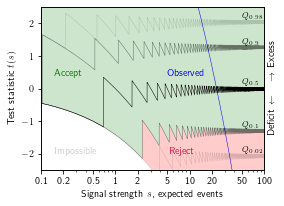

In [4]:
def make_plot(mu, ppfs_array, t_obs, t_empty,
              ylim=(-2.5, 2.5),
              ylabel="Test statistic $t(s)$",
              labels=True):
    alphas = [.15, .5, 1, .5, .15]
    label_coords = dict(
        observed=(9, 0.4),
        reject=(8, -2),
        accept=(0.15, 0.4),
        impossible=(0.15, -2),
    )

    plt.figure(figsize=(4, 3))

    # Plot observed statistic
    plt.plot(mu, t_obs, color='b', linewidth=0.5)

    # Sketch quantiles lines
    mu_label = 50     # s at which to put X% labels
    mu_i = np.argmin(np.abs(mu - mu_label))
    for i, (q, ppf, alpha) in enumerate(zip(quantiles, ppfs_array, alphas)):

        # Slightly smooth PPF... even with 50k toys/point there is some
        # wiggling
        # ppf = interpolate.UnivariateSpline(mu, ppf, s=0.01)(mu)

        plt.plot(mu, ppf,
                 color='k', alpha=alpha, linewidth=0.5)
        if q == 0.1:
            # Color accept and reject regions for upper limits
            plt.fill_between(mu, t_empty, ppf, color='r', 
                             alpha=0.2, linewidth=0)
            plt.fill_between(mu, ppf, ylim[1], color='g', 
                             alpha=0.2, linewidth=0)
        t = plt.text(mu_label, ppf[mu_i] + 0.08,
                     "$Q_{%s}$" % q,
                     #f"{100 * q:.0f}%", 
                     ha='left', va='bottom',
                     color='k', fontsize=8)

    # Text labels
    if labels:
        plt.text(*label_coords['observed'], "Observed", 
                 fontsize=10,
                 c='b', ha='center')
        plt.text(*label_coords['reject'], "Reject", c='crimson', ha='center')
        plt.text(*label_coords['accept'], "Accept", c='g')
        plt.text(*label_coords['impossible'], "Impossible", c='k', alpha=0.2)

    ax = plt.gca()
    plt.xscale('log')
    plt.xlabel("Signal strength $s$, expected events")
    plt.xlim(0.1, 100)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
    plt.xticks([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100])

    plt.ylim(*ylim)
    plt.ylabel(ylabel)

    ax2 = plt.twinx()
    plt.ylabel(r"Deficit $\leftarrow \;\;\;\;\; \rightarrow$ Excess")
    plt.tick_params(right=False, labelright=False)

make_plot(mu, ppf_t0, t_obs, t_empty)

for fmt in 'png', 'pdf':
    plt.savefig(f'neyman_example.{fmt}',
                dpi=200, bbox_inches='tight')
plt.show()

In [5]:
hp.poisson_ul(len(data))

30.453303513724187

# Same for deficit hawk

In [6]:
stat = hp.AllRegionSimpleHawk(
    signal, 
    signal_only=True,
    regions_type='left'
    ).with_stored_dist('lr_oneside')
ul = hp.UpperLimit(stat, anchors=hp.DEFAULT_RATE_GRID.tolist())

In [7]:
mu = hp.DEFAULT_RATE_GRID.copy()
mu = mu[mu < 150]#[::3]
ppf_H = stat.dist.ppf(rate=mu, quantiles=quantiles).T
assert ppf_H.shape == (len(quantiles), len(mu))

t_obs = stat(data=data).compute(rate=mu)
t_empty = stat(data=np.array([])).compute(rate=mu)

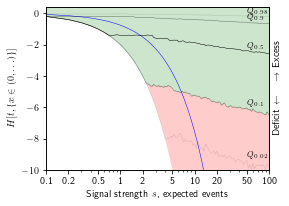

In [8]:
make_plot(mu, ppf_H, t_obs, t_empty, ylim=(-10, 0.4), labels=False,
          ylabel=r"$H[t, \{x \in (0,\ldots)\}]$")
for fmt in 'png', 'pdf':
    plt.savefig(f'neyman_hawk.{fmt}',
                dpi=200, bbox_inches='tight')